In [ ]:
!bash download_dataset.sh monet2photo

In [ ]:
!bash download_dataset.sh cezanne2photo

In [ ]:
!bash download_dataset.sh ukiyoe2photo

In [ ]:
!bash download_dataset.sh vangogh2photo

MAIN

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils as vutils

from networks import Generator, Critic
from config import *
from data import *

import os

In [4]:
####################
# Make directories #
####################

try:
    if TRAIN:
        # Checkpoint directories
        if not os.path.exists(CKPT_DIR):
            os.mkdir(CKPT_DIR)
        for style in STYLES:
            if not os.path.exists(os.path.join(CKPT_DIR, style)):
                os.mkdir(os.path.join(CKPT_DIR, style))
    else:
        # Sample directories
        if not os.path.exists(SAMPLE_DIR):
            os.mkdir(SAMPLE_DIR)
        
        for style in STYLES:
            if not os.path.exists(os.path.join(SAMPLE_DIR, style)):
                os.mkdir(os.path.join(SAMPLE_DIR, style))
                # Make three directories
                os.mkdir(os.path.join(SAMPLE_DIR, style, OUT_STY_DIR))  # Stylized images here
                os.mkdir(os.path.join(SAMPLE_DIR, style, OUT_REC_DIR))  # Reconstructed images here
except:
    print("Directories already exist!")



In [5]:
####################
# Load the dataset #
####################

if TRAIN:
    # Make experiments reproducible
    _ = torch.manual_seed(RANDOM_SEED)
    
    # Load the datasets
    X_set, Y_set = load_data()

    # Load infinite data
    X_data = get_infinite_X_data(X_set)
    Y_data = get_infinite_Y_data(Y_set)

    print("Loaded dataset")



Dataset Details
X_set batches: 38
Y_set batches: 38

Loaded dataset


In [6]:
########################################################
# Define device, neural nets, losses, optimizers, etc. #
########################################################

# Automatic GPU/CPU device placement
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Networks
C_X = Critic().to(device)   # Criticizes X data
C_Y = Critic().to(device)   # Criticizes Y data
G = Generator(upsample=UPSAMPLE).to(device) # Translates X -> Y
F = Generator(upsample=UPSAMPLE).to(device) # Translates Y -> X

# Losses
l1_loss = nn.L1Loss()

# Optimizers
C_X_optim = optim.Adam(C_X.parameters(), lr=LR, betas=(BETA1, BETA2))
C_Y_optim = optim.Adam(C_Y.parameters(), lr=LR, betas=(BETA1, BETA2))
G_optim =   optim.Adam(G.parameters(),   lr=LR, betas=(BETA1, BETA2))
F_optim =   optim.Adam(F.parameters(),   lr=LR, betas=(BETA1, BETA2))


In [7]:
###############
# Training 🧠 #
###############

def train():

    # Status
    print("Begin training!")

    # Load the checkpoints from `BEGIN_ITER`
    try:
        # Get checkpoint paths
        g_model_path =   os.path.join(CKPT_DIR, TRAIN_STYLE, f"G_{BEGIN_ITER}.pth")
        f_model_path =   os.path.join(CKPT_DIR, TRAIN_STYLE, f"F_{BEGIN_ITER}.pth")
        c_x_model_path = os.path.join(CKPT_DIR, TRAIN_STYLE, f"C_X_{BEGIN_ITER}.pth")
        c_y_model_path = os.path.join(CKPT_DIR, TRAIN_STYLE, f"C_Y_{BEGIN_ITER}.pth")

        # Load parameters from checkpoint paths
        G.load_state_dict(torch.load(g_model_path,     map_location=device))
        F.load_state_dict(torch.load(f_model_path,     map_location=device))
        C_X.load_state_dict(torch.load(c_x_model_path, map_location=device))
        C_Y.load_state_dict(torch.load(c_y_model_path, map_location=device))
        
        # Status
        print(f"Training: Loaded the checkpoints from {BEGIN_ITER}th iteration.")
    except:
        # Status
        print(f"Training: Couldn't load the checkpoints from {BEGIN_ITER}th iteration.")

    # Now finally begin training!
    for i in range(BEGIN_ITER, END_ITER + 1):
        
        # Sample safely
        x, y = safe_sampling(X_data, Y_data, device)

        #################
        # Train Critics #
        #################

        # Update gradient computation:
        # ∙ 👎 Generators
        # ∙ 👍 Critics
        for param in G.parameters():
            param.requires_grad_(False)
        for param in F.parameters():
            param.requires_grad_(False)
        for param in C_X.parameters():
            param.requires_grad_(True)
        for param in C_Y.parameters():
            param.requires_grad_(True)

        for j in range(2):

            # Forward passes:
            # ∙ X -> Y
            # ∙ Y -> X

            # Domain translation: X -> Y
            with torch.no_grad():
                G_x = G(x)      # G(x),     X -> Y
            C_Y_G_x = C_Y(G_x)  # Cy(G(x)), fake score
            C_y_y = C_Y(y)      # Cy(y),    real score

            # Domain translation: Y -> X
            with torch.no_grad():
                F_y = F(y)      # F(y),     Y -> X
            C_X_F_y = C_X(F_y)  # Cx(F(y)), fake score
            C_X_x = C_X(x)      # Cx(x),    real score

            # Zerofy the gradients
            C_X_optim.zero_grad()
            C_Y_optim.zero_grad()

            # Compute the losses:
            # ∙ QP-div loss (critizing x data),     Y -> X
            # ∙ QP-div loss (critizing y data),     X -> Y

            # QP-div loss (critizing x data)
            x_loss = C_X_x - C_X_F_y    # real score - fake score
            if NORM == "l1":
                x_norm = LAMBDA * (x - F_y).abs().mean()
            elif NORM == "l2":
                x_norm = LAMBDA * ((x - F_y)**2).mean().sqrt()
            x_loss = -x_loss + 0.5 * x_loss**2 / x_norm
            x_loss = x_loss.mean()

            # QP-div loss (critizing y data)
            y_loss = C_y_y - C_Y_G_x    # real score - fake score
            if NORM == "l1":
                y_norm = LAMBDA * (y - G_x).abs().mean()
            elif NORM == "l2":
                y_norm = LAMBDA * ((y - G_x)**2).mean().sqrt()
            y_loss = -y_loss + 0.5 * y_loss**2 / y_norm
            y_loss = y_loss.mean()

            # Total loss
            c_loss = x_loss + y_loss

            # Compute gradients
            c_loss.backward()

            # Update the networks
            C_Y_optim.step()
            C_X_optim.step()

        ####################
        # Train Generators #
        ####################

        # Update gradient computation:
        # ∙ 👍 Generators
        # ∙ 👎 Critics
        for param in G.parameters():
            param.requires_grad_(True)
        for param in F.parameters():
            param.requires_grad_(True)
        for param in C_X.parameters():
            param.requires_grad_(False)
        for param in C_Y.parameters():
            param.requires_grad_(False)

        for j in range(1):

            # Forward passes:
            # ∙ X -> Y
            # ∙ Y -> X
            # ∙ X -> Y -> X
            # ∙ Y -> X -> Y

            # Domain translation: X -> Y
            G_x = G(x)          # G(x),     X -> Y
            C_Y_G_x = C_Y(G_x)  # Cy(G(x)), fake score
            C_y_y = C_Y(y)      # Cy(y),    real score

            # Domain translation: Y -> X
            F_y = F(y)          # F(y),     Y -> X
            C_X_F_y = C_X(F_y)  # Cx(F(y)), fake score
            C_X_x = C_X(x)      # Cx(x),    real score

            # Cycle-consistent translations
            F_G_x = F(G_x)      # F(G(x)), X -> Y -> X
            G_F_y = G(F_y)      # G(F(y)), Y -> X -> Y

            # Zerofy the gradients
            G_optim.zero_grad()
            F_optim.zero_grad()

            # Compute the losses:
            # ∙ QP-div loss (critizing x data),     Y -> X
            # ∙ QP-div loss (critizing y data),     X -> Y
            # ∙ Cycle-consistency loss,             || F(G(x)) - x || L1
            # ∙ Cycle-consistency loss,             || G(F(y)) - y || L1
            # ∙ Identity loss,                      || G(x) - y || L1
            # ∙ Identity loss,                      || F(y) - x || L1
            
            # QP-div losses
            x_loss = C_X_x - C_X_F_y        # real score - fake score
            y_loss = C_y_y - C_Y_G_x        # real score - fake score
            x_loss = x_loss.mean()
            y_loss = y_loss.mean()

            # Cycle-consistency losses
            x_cyc_loss = l1_loss(F_G_x, x)  # || F(G(x)) - x || L1
            y_cyc_loss = l1_loss(G_F_y, y)  # || G(F(y)) - y || L1
            x_cyc_loss = x_cyc_loss.mean()
            y_cyc_loss = y_cyc_loss.mean()
            
            # Identity losses
            x_id_loss = l1_loss(G_x, y)     # || G(x) - y || L1
            y_id_loss = l1_loss(F_y, x)     # || F(y) - x || L1
            x_id_loss = x_id_loss.mean()
            y_id_loss = y_id_loss.mean()

            # Total loss
            g_loss = x_loss + y_loss
            g_loss += CYC_WEIGHT * (x_cyc_loss + y_cyc_loss)
            g_loss += ID_WEIGHT * (x_id_loss + y_id_loss)

            # Compute gradients
            g_loss.backward()

            # Update the networks
            G_optim.step()
            F_optim.step()

        #############
        # Log stats #
        #############

        if i % ITERS_PER_LOG == 0:
            # Status
            print(f"iter: {i} c_loss: {c_loss} g_loss: {g_loss}")

        if i % ITERS_PER_CKPT == 0:
            # Get checkpoint paths
            g_model_path =   os.path.join(CKPT_DIR, TRAIN_STYLE, f"G_{i}.pth")
            f_model_path =   os.path.join(CKPT_DIR, TRAIN_STYLE, f"F_{i}.pth")
            c_x_model_path = os.path.join(CKPT_DIR, TRAIN_STYLE, f"C_X_{i}.pth")
            c_y_model_path = os.path.join(CKPT_DIR, TRAIN_STYLE, f"C_Y_{i}.pth")

            # Save the checkpoints
            torch.save(G.state_dict(),   g_model_path)
            torch.save(F.state_dict(),   f_model_path)
            torch.save(C_X.state_dict(), c_x_model_path)
            torch.save(C_Y.state_dict(), c_y_model_path)

            # Status
            print(f"Saved checkpoints at {i}th iteration.")
    # Status
    print("Finished Training!")



In [35]:
################
# Inference 🧠 #
################

def infer(iteration, style, img_name, in_img_dir, out_rec_dir, out_sty_dir, img_size=None):
    
    print("iteration = ", iteration)
    # Set neural nets to evaluation mode
    G.eval()
    F.eval()

    # Try loading models from checkpoints at `iteration`
    try:
        # Get checkpoint paths
        g_model_path = os.path.join(CKPT_DIR, style, f"G_{iteration}.pth")
        f_model_path = os.path.join(CKPT_DIR, style, f"F_{iteration}.pth")
        
        # Load parameters from checkpoint paths
        G.load_state_dict(torch.load(g_model_path, map_location=device))
        F.load_state_dict(torch.load(f_model_path, map_location=device))
        
        # Status
        print(f"Inference: Loaded the checkpoints from {iteration}th iteration.")
    except:
        # Status
        print(f"Inference: Couldn't load the checkpoints from {iteration}th iteration.")
        raise

    # Minor transforms
    if img_size == None:
        loader = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
        ])
    else:
        loader = transforms.Compose([
            transforms.Resize(img_size),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
        ])

    from PIL import Image

    def image_loader(image_name):
        image = Image.open(image_name)
        image = loader(image).unsqueeze(0)  # Add a fake batch dimension
        return image.to(device, torch.float)
    
    # style_a = image_loader(out_img_path)
    in_img_path = os.path.join(in_img_dir, img_name)
    in_img = image_loader(in_img_path)
    
    with torch.no_grad():
        print("Stylization")
        sty_img = F(in_img)     # Y -> X
        print("Reconstruction")
        rec_img = G(sty_img)    # X -> Y
    
    # WARNING: Please do not change this code snippet with a closed mind. 🤪👻
    only_img_name = img_name.split('.')[0]
    img_type = img_name.split('.')[1]

    # Set up names
    out_sty_name = f"sty_{only_img_name}_{style}_{iteration}.{img_type}"
    out_rec_name = f"rec_{only_img_name}_{style}_{iteration}.{img_type}"
    
    # Set up paths
    sty_path = os.path.join(SAMPLE_DIR, style, out_sty_dir, out_sty_name)
    rec_path = os.path.join(SAMPLE_DIR, style, out_rec_dir, out_rec_name)
    
    # Save image grids
    vutils.save_image(sty_img, sty_path, normalize=True)
    vutils.save_image(rec_img, rec_path, normalize=True)
    
    # Status
    print(f"Saved {rec_path}")
    print(f"Saved {sty_path}")

    # Return
    return sty_path, rec_path



In [ ]:
IMG_NAME = "demo1.jpg"
INFER_STYLE = "color"
TRAIN = False
BEGIN_ITER = 0
END_ITER = 20
INFER_ITER = 15000

if __name__ == "__main__":
    
    if TRAIN:
        train()
    else:
        infer(
            iteration=INFER_ITER,
            style=INFER_STYLE,
            img_name=IMG_NAME,
            in_img_dir=IN_IMG_DIR,
            out_rec_dir=OUT_REC_DIR,
            out_sty_dir=OUT_STY_DIR,
            img_size=IMG_SIZE
        )
    


Begin training!
Training: Couldn't load the checkpoints from 0th iteration.
iter: 0 c_loss: 1.2178510427474976 g_loss: 13.638105392456055
Saved checkpoints at 0th iteration.
iter: 1 c_loss: -0.13216142356395721 g_loss: 12.924322128295898
Saved checkpoints at 1th iteration.
iter: 2 c_loss: -0.5198467969894409 g_loss: 11.963750839233398
Saved checkpoints at 2th iteration.
iter: 3 c_loss: -0.6448197960853577 g_loss: 10.734578132629395
Saved checkpoints at 3th iteration.
iter: 4 c_loss: -0.5911527872085571 g_loss: 10.649738311767578
Saved checkpoints at 4th iteration.
iter: 5 c_loss: -0.5358226299285889 g_loss: 9.440223693847656
Saved checkpoints at 5th iteration.
iter: 6 c_loss: -0.3216649889945984 g_loss: 8.386070251464844
Saved checkpoints at 6th iteration.
iter: 7 c_loss: -0.43390578031539917 g_loss: 8.623525619506836
Saved checkpoints at 7th iteration.
iter: 8 c_loss: -0.00899609923362732 g_loss: 7.665021896362305
Saved checkpoints at 8th iteration.
iter: 9 c_loss: -0.9277944564819336

iteration =  15000
Inference: Loaded the checkpoints from 15000th iteration.
Stylization
Reconstruction
Saved samples/ce/rec/rec_meow_ce_15000.jpg
Saved samples/ce/sty/sty_meow_ce_15000.jpg
iteration =  15000
Inference: Loaded the checkpoints from 15000th iteration.
Stylization
Reconstruction
Saved samples/mo/rec/rec_meow_mo_15000.jpg
Saved samples/mo/sty/sty_meow_mo_15000.jpg
iteration =  12000
Inference: Loaded the checkpoints from 12000th iteration.
Stylization
Reconstruction
Saved samples/uk/rec/rec_meow_uk_12000.jpg
Saved samples/uk/sty/sty_meow_uk_12000.jpg
iteration =  15000
Inference: Loaded the checkpoints from 15000th iteration.
Stylization
Reconstruction
Saved samples/vg/rec/rec_meow_vg_15000.jpg
Saved samples/vg/sty/sty_meow_vg_15000.jpg


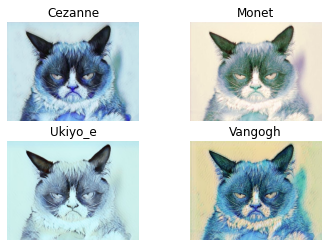

In [38]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

lstStyles = {
    "ce": "Cezanne",
    "mo": "Monet",
    "uk": "Ukiyo_e",
    "vg": "Vangogh",
}

IMG_NAME = "meow.jpg"
# INFER_STYLE = "color"
TRAIN = False
outputs = {}

for style in lstStyles.keys():
    if style=="uk":
        INFER_ITER = 12000
    else:
        INFER_ITER = 15000

    sty_path, rec_path = infer(   iteration=INFER_ITER,
                                style=style,
                                img_name=IMG_NAME,
                                in_img_dir=IN_IMG_DIR,
                                out_rec_dir=OUT_REC_DIR,
                                out_sty_dir=OUT_STY_DIR,
                                img_size=IMG_SIZE
                            )
    outputs[style] = sty_path
    
rows = 2
columns = 2
fig = plt.figure()
i=0
for style in lstStyles.keys():
    i+=1
    fig.add_subplot(rows, columns, i)
    img = cv2.imread(outputs[style])
    plt.imshow(img)
    plt.axis('off')
    plt.title(lstStyles[style])

Src: https://github.com/rahulbhalley/cyclegan-qp

Epochs | Times
---- | -----
10 | 39m 40s
15 | 54m 34s
20 | 63m 36s

### Loss

iter | c_loss | g_loss
:---: | :---: | :----:
iter: 0 | c_loss: 1.2178510427474976 | g_loss: 13.638105392456055
iter: 1 | c_loss: -0.13216142356395721 | g_loss: 12.924322128295898
iter: 2 | c_loss: -0.5198467969894409 | g_loss: 11.963750839233398
iter: 3 | c_loss: -0.6448197960853577 | g_loss: 10.734578132629395
iter: 4 | c_loss: -0.5911527872085571 | g_loss: 10.649738311767578
iter: 5 | c_loss: -0.5358226299285889 | g_loss: 9.440223693847656
iter: 6 | c_loss: -0.3216649889945984 | g_loss: 8.386070251464844
iter: 7 | c_loss: -0.43390578031539917 | g_loss: 8.623525619506836
iter: 8 | c_loss: -0.00899609923362732 | g_loss: 7.665021896362305
iter: 9 | c_loss: -0.9277944564819336 | g_loss: 8.797774314880371
iter: 10 | c_loss: -1.0305500030517578 | g_loss: 7.43509578704834
iter: 11 | c_loss: -0.857285737991333 | g_loss: 7.3472747802734375
iter: 12 | c_loss: -0.2691907584667206 | g_loss: 6.779996395111084
iter: 13 | c_loss: -0.6615128517150879 | g_loss: 7.279688835144043
iter: 14 | c_loss: -0.7315434813499451 | g_loss: 7.455419540405273
iter: 15 | c_loss: -0.5647450685501099 | g_loss: 7.089359760284424
iter: 16 | c_loss: -0.8899028897285461 | g_loss: 6.947590351104736
iter: 17 | c_loss: -1.0619173049926758 | g_loss: 7.834425926208496
iter: 18 | c_loss: -0.6743765473365784 | g_loss: 7.864903926849365
iter: 19 | c_loss: -0.7689822912216187 | g_loss: 7.261453151702881
iter: 20 | c_loss: -0.32039764523506165 | g_loss: 5.865560054779053
